# Bayesian optimization

Here, <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> library is used to find optimal hyperparameters for the XGBoost and SVR models on the diabetes dataset provided in sklearn.

In [1]:
#!pip install GPyOpt

In [2]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
%matplotlib inline

In [3]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

### XGBoost optimisation

Cross-validation score will be used to estimate accuracy. The goal is to tune ```max_depth```, ```learning_rate```, and ```n_estimators``` parameters for the XGBoostRegressor algorithm.

In [4]:
#score - optimiser will try to find min, so add a - sign
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4],
                    objective='reg:squarederror'), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [5]:
baseline = -cross_val_score(
    XGBRegressor(objective='reg:squarederror'), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

3437.074407214106

In [6]:
#bounds - define continuous variables first, then discrete
bounds = [    
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [7]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [8]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

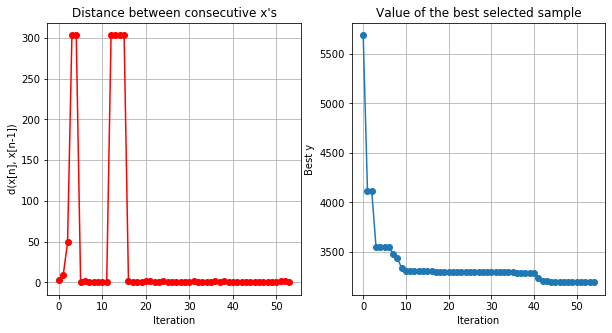

In [9]:
optimizer.plot_convergence()

Best parameter values:

In [10]:
optimizer.X[np.argmin(optimizer.Y)]

array([4.69015440e-02, 1.17203648e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [11]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 3190.9836021374917 Gain: 107.7120673673086


In [12]:
performance_boost = baseline/np.min(optimizer.Y) 
print(performance_boost*100)

107.7120673673086


### SVR optimisation

Now a SVR model will be tuned, by finding optimal values for 3 parameters: `C`, `epsilon` and `gamma`.

MPI is used as an acquisition function with weight 0.1.

In [23]:
def svrModel(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                SVR(C=parameters[0],
                    epsilon=parameters[1],
                    gamma=parameters[2]),
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [24]:
baseline = -cross_val_score(SVR(), X, y, scoring='neg_mean_squared_error').mean()
baseline

4976.655882526393

In [25]:
bounds = [
            {'name': 'C', 'type': 'continuous', 'domain': (1e-5, 1000)},
            {'name': 'epsilon', 'type': 'continuous', 'domain': (1e-5, 10)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (1e-5, 10)}
         ]

In [26]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=svrModel, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)

In [27]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

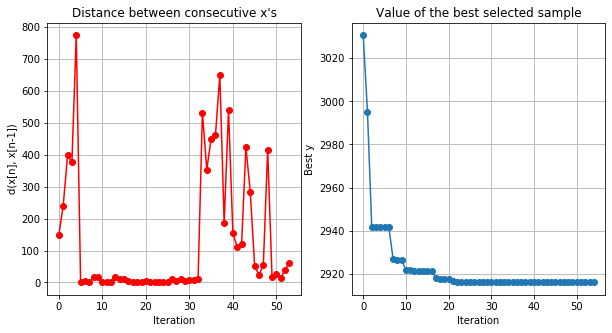

In [28]:
optimizer.plot_convergence()

In [29]:
optimizer.X[np.argmin(optimizer.Y)]

array([87.86062849,  5.45467014, 10.        ])

In [30]:
print('MSE:', np.min(optimizer.Y), 'Gain:', baseline/np.min(optimizer.Y))

MSE: 2916.0271532332617 Gain: 1.7066562212935248


In [31]:
best_C = optimizer.X[np.argmin(optimizer.Y)][0] 
best_epsilon = optimizer.X[np.argmin(optimizer.Y)][1] 
best_gamma = optimizer.X[np.argmin(optimizer.Y)][2] 
print('Best C:', best_epsilon)
print('Best epsilon:', best_C)
print('Best gamma:', best_gamma)

Best C: 5.454670138446936
Best epsilon: 87.8606284873888
Best gamma: 10.0


In [32]:
performance_boost = baseline_svr/np.min(optimizer.Y) 
print(performance_boost*100)

170.66562212935247
